In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.discrete.discrete_model import Logit 
from scipy import stats
sns.set_style("darkgrid")
plt.rcParams['savefig.dpi'] = 100 
plt.rcParams['figure.dpi'] = 100
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Load data

In [2]:
dates=['delivered_date', 'payment_received_date']
df_mtxn = pd.read_csv(\
'/Volumes/GoogleDrive/My Drive/wish_local/fusion_package_breakdown/store_cannibalization/data/m_transaction_id_mx_123456_test_geohashes.csv',\
                parse_dates=dates, infer_datetime_format=True)

/Users/mshi/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df_mtxn['geohash_size4'] = df_mtxn['geohash'].apply(lambda x: x[:4] if type(x)==str else x)
df_mtxn['combined'] = df_mtxn['orig_num_fm'].apply(lambda x: 1 if x > 1 else 0)
df_mtxn['combined_2'] = df_mtxn['orig_num_fm'].apply(lambda x: 1 if x > 2 else 0)
df_mtxn['delivered_week'] = df_mtxn['delivered_date'].apply(lambda x: (x - timedelta(days=x.weekday())).date())

In [4]:
df_mtxn = df_mtxn[~((df_mtxn['combined_to'].isna()) |\
          (df_mtxn['orig_user_store_dist'].isna()) | \
          (df_mtxn['orig_user_store_dist']==np.inf))]

In [23]:
df.head()

,first_mile_tracking_id,store_id,combined_to,delivered,delivered_date,user_id,orig_num_fm,last_combined_time,orig_user_store_dist,geohash,store_state,geohash_size4,combined,combined_2,delivered_week,logistics_profit_cny
0,WI001414596527EPC,5d812de36b6e297d301dd461,F3552820111400SM,1610003802,2021-01-06,5a9725e98aeedb7d07c55eab,7,1.611407e+09,0.04,9sm8ds,1,9sm8,1,1,2021-01-04,NaN
1,WI001416130707EPC,5da9038174711f04db48ca97,MMXQP008407682R,1611101054,2021-01-19,56247ae230291c11d2e6762c,7,1.609550e+09,1.02,9sm8dk,1,9sm8,1,1,2021-01-18,NaN
2,WI001416676302EPC,5dd5b2c64cc6673f804a6d3a,MMXQP008450955R,1610773438,2021-01-15,5ddb29d3c54d70bc7d983f43,3,1.612108e+09,1.58,9scngz,1,9scn,1,1,2021-01-11,NaN
3,WI001416960488EPC,5d7c38183f0bbc4712ebf264,MMXQP008535125R,1610345418,2021-01-10,5e90752ab74957fed6c00bd0,3,1.606371e+09,3.44,9thbru,1,9thb,1,1,2021-01-04,NaN
4,WI001417341778EPC,5eb1d232b1009e9f26833154,MMXQP008465265R,1612559400,2021-02-05,5bf2cf83747f0b2994ca1a5f,17,1.610035e+09,1.39,9ewt9e,1,9ewt,1,1,2021-02-01,NaN


In [5]:
df_mtxn.shape, df_mtxn['first_mile_tracking_id'].nunique()

((463557, 35), 411857)

## First mile package level

In [6]:
df = df_mtxn[['first_mile_tracking_id', 'store_id', 'combined_to', \
    'delivered', 'delivered_date', 'user_id', 'orig_num_fm',\
    'last_combined_time', 'orig_user_store_dist', 'geohash', 'store_state', 'geohash_size4', 'combined',
       'combined_2', 'delivered_week', 'logistics_profit_cny']].drop_duplicates()
df.shape

(411857, 16)

In [7]:
df.shape, df['first_mile_tracking_id'].nunique()

((411857, 16), 411857)

In [22]:
df.head()

,first_mile_tracking_id,store_id,combined_to,delivered,delivered_date,user_id,orig_num_fm,last_combined_time,orig_user_store_dist,geohash,store_state,geohash_size4,combined,combined_2,delivered_week,logistics_profit_cny
0,WI001414596527EPC,5d812de36b6e297d301dd461,F3552820111400SM,1610003802,2021-01-06,5a9725e98aeedb7d07c55eab,7,1.611407e+09,0.04,9sm8ds,1,9sm8,1,1,2021-01-04,NaN
1,WI001416130707EPC,5da9038174711f04db48ca97,MMXQP008407682R,1611101054,2021-01-19,56247ae230291c11d2e6762c,7,1.609550e+09,1.02,9sm8dk,1,9sm8,1,1,2021-01-18,NaN
2,WI001416676302EPC,5dd5b2c64cc6673f804a6d3a,MMXQP008450955R,1610773438,2021-01-15,5ddb29d3c54d70bc7d983f43,3,1.612108e+09,1.58,9scngz,1,9scn,1,1,2021-01-11,NaN
3,WI001416960488EPC,5d7c38183f0bbc4712ebf264,MMXQP008535125R,1610345418,2021-01-10,5e90752ab74957fed6c00bd0,3,1.606371e+09,3.44,9thbru,1,9thb,1,1,2021-01-04,NaN
4,WI001417341778EPC,5eb1d232b1009e9f26833154,MMXQP008465265R,1612559400,2021-02-05,5bf2cf83747f0b2994ca1a5f,17,1.610035e+09,1.39,9ewt9e,1,9ewt,1,1,2021-02-01,NaN


## Load test group assignment

In [9]:
final_assign = pd.read_csv(
'/Volumes/GoogleDrive/My Drive/wish_local/fusion_package_breakdown/store_cannibalization/data/exp_assign_seed22.csv')

In [10]:
final_assign

,geohash,store_id,show
0,9gd6bb,5d7c154d6a9d90393f1d8c7f,0
1,9g6hr4,5e2b5c2c8faef029f9523b21,0
2,9g3w2t,5ddd9645801ecf0b403be86c,1
3,9g15zf,5e31f848e19bb72cbd315381,1
4,9thbru,5e38998f12e6656521420c79,1
5,9g3xjb,5d601b0145df540409d88c0b,1
6,9g3x43,5d24dfbe90532b26d92f00b1,1
7,9g3w0q,5d670ee6d17da954b85b381a,1
8,9mtj65,5dfbeb448403b82e48d2539a,0
9,9g6h6y,5db9f74a3b15c82883a87b24,0


In [15]:
final_assign.groupby(['show'])[['geohash', 'store_id']].nunique()

,geohash,store_id
show,,
0,484,1340
1,514,1367


In [11]:
df_pool = pd.merge(df, final_assign, on='geohash', how='left', suffixes=('', '_assign'))

In [12]:
df_pool.head()

,first_mile_tracking_id,store_id,combined_to,delivered,delivered_date,user_id,orig_num_fm,last_combined_time,orig_user_store_dist,geohash,store_state,geohash_size4,combined,combined_2,delivered_week,logistics_profit_cny,store_id_assign,show
0,WI001414596527EPC,5d812de36b6e297d301dd461,F3552820111400SM,1610003802,2021-01-06,5a9725e98aeedb7d07c55eab,7,1.611407e+09,0.04,9sm8ds,1,9sm8,1,1,2021-01-04,NaN,5d812de36b6e297d301dd461,0
1,WI001414596527EPC,5d812de36b6e297d301dd461,F3552820111400SM,1610003802,2021-01-06,5a9725e98aeedb7d07c55eab,7,1.611407e+09,0.04,9sm8ds,1,9sm8,1,1,2021-01-04,NaN,5db8bbe63eca130e00b6a9da,0
2,WI001414596527EPC,5d812de36b6e297d301dd461,F3552820111400SM,1610003802,2021-01-06,5a9725e98aeedb7d07c55eab,7,1.611407e+09,0.04,9sm8ds,1,9sm8,1,1,2021-01-04,NaN,5d41c7d2e13a7e7d40f928c1,0
3,WI001414596527EPC,5d812de36b6e297d301dd461,F3552820111400SM,1610003802,2021-01-06,5a9725e98aeedb7d07c55eab,7,1.611407e+09,0.04,9sm8ds,1,9sm8,1,1,2021-01-04,NaN,5ddc5b34801ecf0a80391cf2,0
4,WI001416130707EPC,5da9038174711f04db48ca97,MMXQP008407682R,1611101054,2021-01-19,56247ae230291c11d2e6762c,7,1.609550e+09,1.02,9sm8dk,1,9sm8,1,1,2021-01-18,NaN,5dc1ed4e7ad7c800800a525a,0


# Check assignment trend

Text(0, 0.5, 'Avg logistics profit (CNY)')

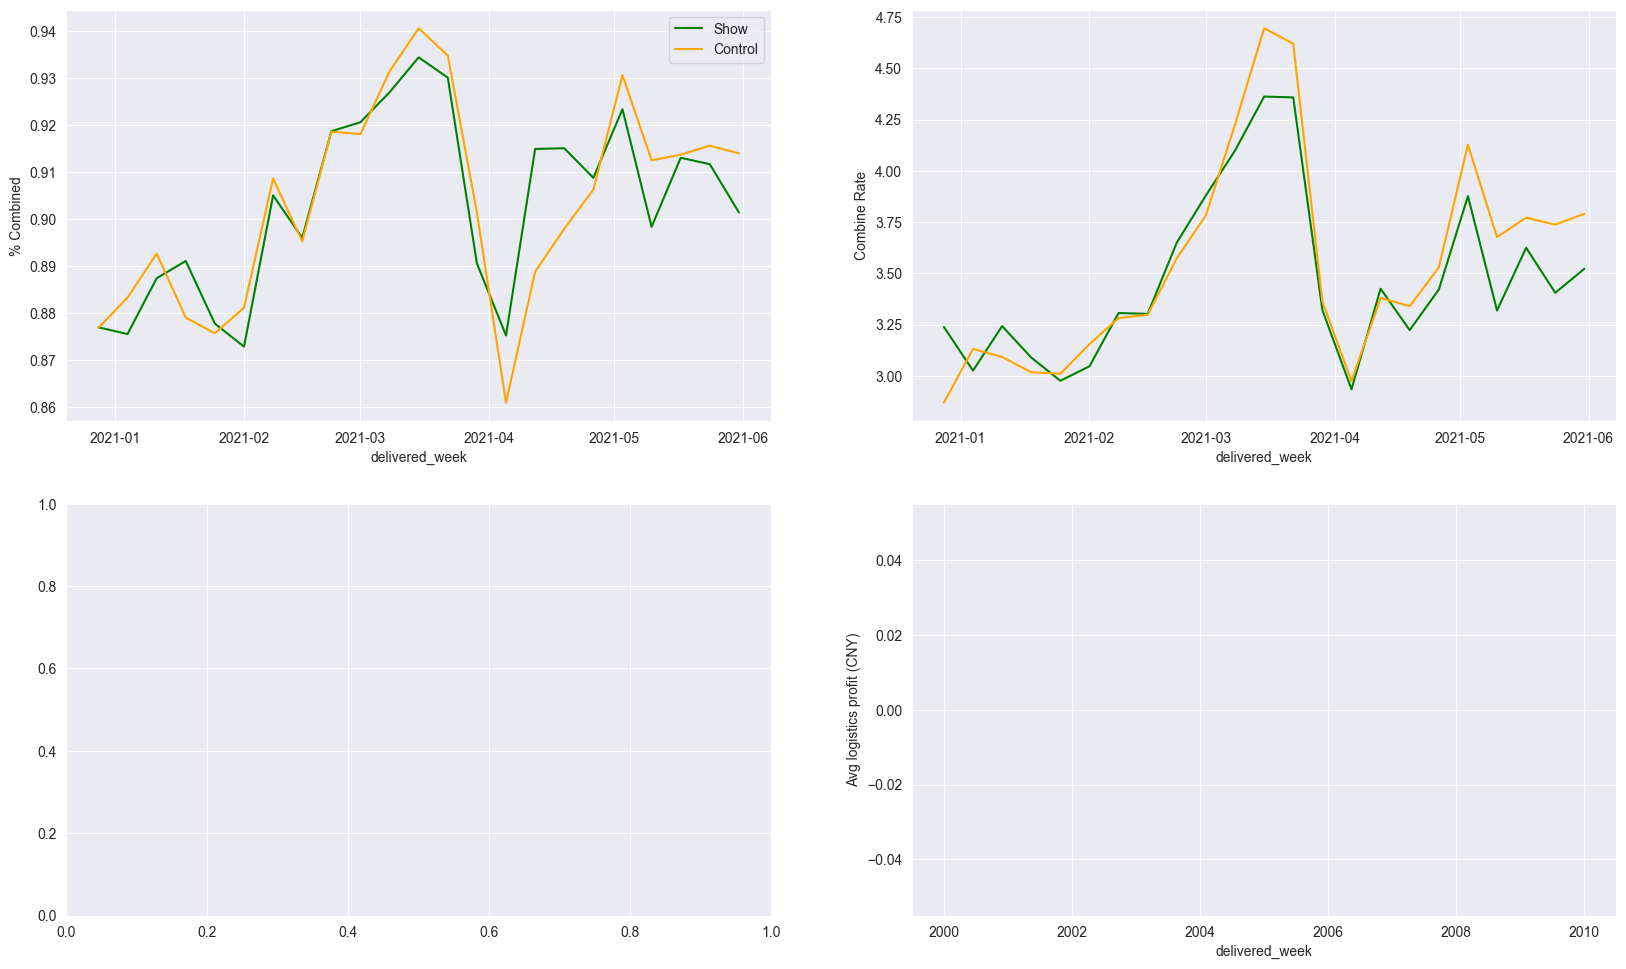

In [20]:
## plot
fig, axs= plt.subplots(nrows=2, ncols=2, figsize=(20,12))
j=0
# % Combined
df_pool[df_pool['show']==1].groupby('delivered_week')['combined'].mean().plot(c='green', ax=axs[j,0], label='Show')
df_pool[df_pool['show']==0].groupby('delivered_week')['combined'].mean().plot(c='orange', ax=axs[j,0], label='Control')

# df_pool[df_pool['exp_group']=='show'].groupby('delivered_week')['combined_2'].mean().plot(c='green', ax=axs[j,0])
# df_pool[df_pool['exp_group']=='control'].groupby('delivered_week')['combined_2'].mean().plot(c='orange', ax=axs[j,0])

# axs[j,0].vlines(launch_date, ymin=0.85, ymax=0.95, color='red')
axs[j,0].set_ylabel('% Combined')
axs[j,0].legend()


# combine rate
b = df_pool.groupby(['delivered_week', 'show', 'geohash']).agg(\
                                                           {'combined': 'mean',
                                                            'combined_2': 'mean',
                                                            'first_mile_tracking_id': 'nunique',
                                                            'combined_to': 'nunique',
                                                            'store_id': 'nunique', 
                                                            'user_id': 'nunique'
                                                           })
b = b.reset_index()
b['combine_rate'] = b['first_mile_tracking_id'] / b['combined_to']
b['geohash_size4'] = b['geohash'].apply(lambda x: x[:4])
# b = pd.merge(b, df_pool[['geohash_size4', 'show']].drop_duplicates(), \
#              how='left', on='geohash_size4')


b.groupby(['show', 'delivered_week'])['combine_rate'].mean()[1].plot(c='green', ax=axs[j,1])
b.groupby(['show', 'delivered_week'])['combine_rate'].mean()[0].plot(c='orange', ax=axs[j,1])
# axs[j,1].vlines(launch_date, ymin=2, ymax=5, color='red')
axs[j,1].set_ylabel('Combine Rate')


# profit
df_pool[df_pool['show']==1].groupby('delivered_week')['logistics_profit_cny'].mean().plot(c='green', ax=axs[1,1])
df_pool[df_pool['show']==0].groupby('delivered_week')['logistics_profit_cny'].mean().plot(c='orange', ax=axs[1,1])

# axs[1, 1].vlines(launch_date, ymin=-8, ymax=2, color='red')
axs[1, 1].set_ylabel('Avg logistics profit (CNY)')